In [1]:
import drawSvg as draw
import yt
import numpy as np
import ipywidgets
import matplotlib as mpl

In [2]:
class SVGTitle(draw.TSpan):
    TAG_NAME = 'title'
    hasContent = True

In [3]:
ds = yt.testing.fake_amr_ds(geometry = "cylindrical")

yt : [INFO     ] 2020-10-05 13:16:00,947 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-10-05 13:16:00,948 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-10-05 13:16:00,950 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-10-05 13:16:00,951 Parameters: domain_right_edge         = [1.         1.         6.28318531]
yt : [INFO     ] 2020-10-05 13:16:00,952 Parameters: cosmological_simulation   = 0.0


In [4]:
final_level = 3
grids = []
g = ds.index.select_grids(final_level)[3]
while g is not None:
    grids.append(g)
    g = g.Parent
grids.sort(key = lambda a: a.Level)

yt : [WARNING  ] 2020-10-05 13:16:01,065 In cylindrical geometry, gradient fields may contain artifacts near cartesian axes.


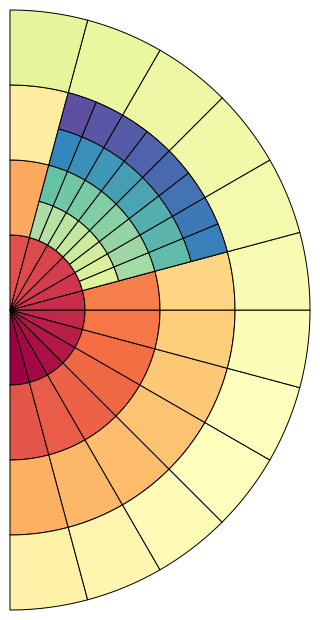

In [13]:
margin = 10
width, height = 300 + 2 * margin, 600 + 2*margin
x_bounds = (0.0, 1.0)
y_bounds = (-1.0, 1.0)
# We want to scale from -1..1 into margin .. width - margin, and same for height
x_sc = lambda v: ((v - x_bounds[0])/(x_bounds[1] - x_bounds[0])) * (width - 2*margin) + margin
y_sc = lambda v: ((v - y_bounds[0])/(y_bounds[1] - y_bounds[0])) * (height - 2*margin) + margin

def draw_wedge(r0, theta0, r1, theta1, fill = "none"):
    p = draw.Path(fill = fill, stroke = "black")
    p.arc(x_sc(0), y_sc(0), x_sc(r0) - x_sc(0), theta0, theta1, cw = False)
    p.arc(x_sc(0), y_sc(0), x_sc(r1) - x_sc(0), theta1, theta0, cw = True, includeL = True)
    p.Z()
    return p

canvas = draw.Drawing(width = width, height = height)
base_group = c = draw.Group(id = "coordinate_space_figure")
canvas.append(base_group)

grids = [
    [0, 1, 4, -90, 90, 12],
    [0.25, 0.75, 4, 15, 75, 8]
]
n_total = sum(_[2] * _[5] for _ in grids)

norm = mpl.colors.Normalize(vmin = 0, vmax=n_total - 1)
cmap = mpl.cm.Spectral

n = 0
for r0, r1, nr, theta0, theta1, ntheta in grids[:]:
    dr = (r1 - r0)/nr
    dtheta = (theta1 - theta0)/ntheta
    for i in range(nr):
        for j in range(ntheta):
            g = draw.Group(id = f"cell_{n:02d}")
            g.append(SVGTitle(f"cell: {i: 2d} {j: 2d}"))
            p = draw_wedge(r0 + dr * i, theta0 + dtheta * j,
                           r0 + dr * (i+1), theta0 + dtheta * (j+1),
                           fill = mpl.colors.to_hex(cmap(norm(n))))
            p.args['data-cell-i'] = f"{i}"
            p.args['data-cell-j'] = f"{j}"
            g.append(p)
            c.append(g)
            n += 1
display(canvas)
canvas.saveSvg("../content/images/indexing/coordinate_space.svg")

{'id': 'cell_79'}